# Features visualization

In [169]:
import torch
import pandas as pd
import os
import warnings
import numpy as np
from tqdm import tqdm
warnings.filterwarnings("ignore")
from models import TransformerRegressionModel
import sys
sys.path.append("/code/LLM-crime")
from custom_clip_train import CLIPModel, CLIPDataset, build_loaders, make_prediction

In [170]:
cfg = 'baseline'
img_feature = np.load(f"/data1/cehou_data/LLM_safety/middle_variables/{cfg}/img_feature.npy")
text_feature = np.load(f"/data1/cehou_data/LLM_safety/middle_variables/{cfg}/text_feature.npy")
predictions = np.load(f"/data1/cehou_data/LLM_safety/middle_variables/{cfg}/predictions.npy")


In [171]:
from sklearn.metrics.pairwise import cosine_similarity

# 计算文本特征之间的余弦相似性
text_feature_similarity = cosine_similarity(text_feature)
img_feature_similarity = cosine_similarity(img_feature)

<Axes: >

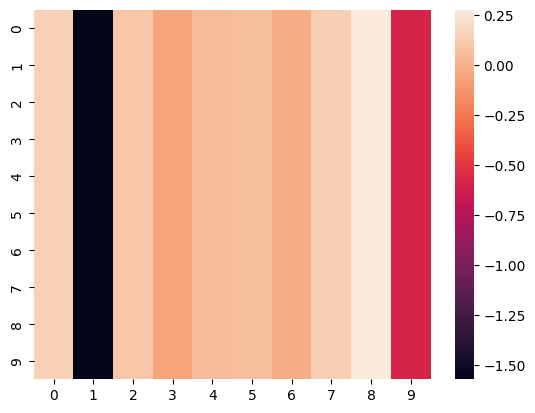

In [172]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.heatmap(text_feature[:10,:10])

## 计算文本间相似性


In [173]:
if cfg == 'baseline':
    data = pd.read_pickle(f"/data1/cehou_data/LLM_safety/dataset_baseline_746.pkl")
else:
    data = pd.read_pickle(f"/data1/cehou_data/LLM_safety/dataset_30_{cfg}_HongKong_murder_746.pkl")
text_describe_list = [data[i]['text_description'] for i in range(len(data))]

In [174]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# 定义两个字符串

def cal_text_similarity(str_list):
    # 将文本转换为tf-idf特征
    vectorizer = TfidfVectorizer()
    tfidf = vectorizer.fit_transform(str_list)
    # 计算两个字符串之间的余弦相似度
    similarity = cosine_similarity(tfidf)
    return similarity

text_similarity = cal_text_similarity(text_describe_list)

In [175]:
# 获取对角线以上上半部分的元素及其位置
upper_triangle_indices = np.triu_indices(text_similarity.shape[0], k=1)
upper_triangle_values = text_similarity[upper_triangle_indices]

# 记录位置
positions = list(zip(upper_triangle_indices[0], upper_triangle_indices[1]))

In [176]:
from PIL import Image
def get_img(dataset, idx):
    for i,path in enumerate(dataset[idx]["GSV_path"]):
        if i == 0:
            GSV_img = np.array(Image.open(path))
        else:
            GSV_img = np.concatenate((GSV_img, np.array(Image.open(path))), axis=1)
    return GSV_img

def cal_img_similarity(dataset, img1_idx, img2_idx):
    img1 = get_img(dataset, img1_idx)
    img2 = get_img(dataset, img2_idx)
    img1_flat = img1.flatten().reshape(1, -1)
    img2_flat = img2.flatten().reshape(1, -1)
    img_similarity = cosine_similarity(img1_flat, img2_flat)
    return img_similarity[0][0]

In [177]:
evaluation_df = pd.DataFrame(columns=['img1_idx', 'img2_idx', 'config', 'text_similarity', 'img_similarity','text_feature_similarity','img_feature_similarity'])
for i in range(25):
    for j in range(25):
        if i < j:
            img_similarity = cal_img_similarity(data, i, j)
            evaluation_df = evaluation_df.append({'img1_idx': i, 'img2_idx': j, 'config':cfg, 'text_similarity': text_similarity[i][j], 'img_similarity': img_similarity, 'text_feature_similarity': text_feature_similarity[i][j], 'img_feature_similarity': img_feature_similarity[i][j]}, ignore_index=True)            
            
evaluation_df.to_csv(f"/data1/cehou_data/LLM_safety/middle_variables/{cfg}/evaluation_df.csv", index=False)

Text(0.95, 0.95, 'Correlation: -0.26')

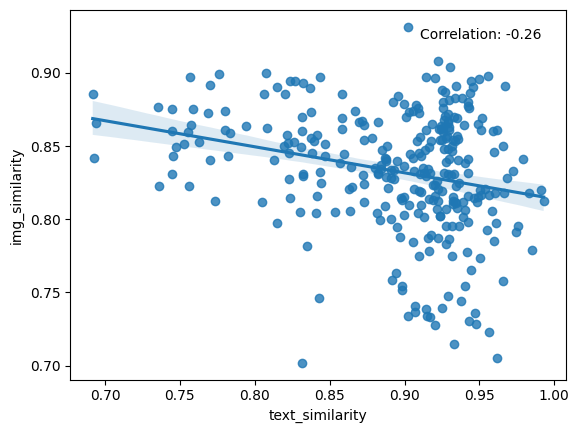

In [178]:

# 计算相关系数
correlation = np.corrcoef(evaluation_df['text_similarity'], evaluation_df['img_similarity'])[0, 1]

sns.regplot(x='text_similarity', y='img_similarity', data=evaluation_df)
# 标记相关系数
plt.text(0.95, 0.95, f'Correlation: {correlation:.2f}', horizontalalignment='right', verticalalignment='top', transform=plt.gca().transAxes)

Text(0.95, 0.95, 'Correlation: nan')

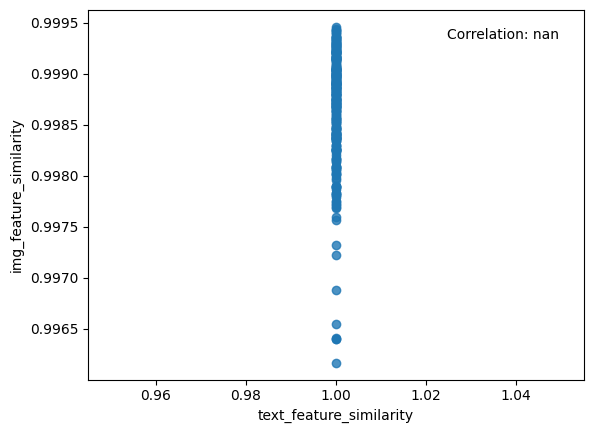

In [179]:
correlation = np.corrcoef(evaluation_df['text_feature_similarity'], evaluation_df['img_feature_similarity'])[0, 1]

sns.regplot(x='text_feature_similarity', y='img_feature_similarity', data=evaluation_df)
# 标记相关系数
plt.text(0.95, 0.95, f'Correlation: {correlation:.2f}', horizontalalignment='right', verticalalignment='top', transform=plt.gca().transAxes)

[[0.9999999  0.9999999  0.9999999  ... 0.9999999  0.99999994 0.99999994]
 [0.9999999  0.9999999  0.9999999  ... 0.9999999  0.99999994 0.99999994]
 [0.9999999  0.9999999  0.9999999  ... 0.9999999  0.99999994 0.99999994]
 ...
 [0.9999999  0.9999999  0.9999999  ... 0.9999999  0.99999994 0.99999994]
 [0.99999994 0.99999994 0.99999994 ... 0.99999994 1.         1.        ]
 [0.99999994 0.99999994 0.99999994 ... 0.99999994 1.         1.        ]]


<Axes: >

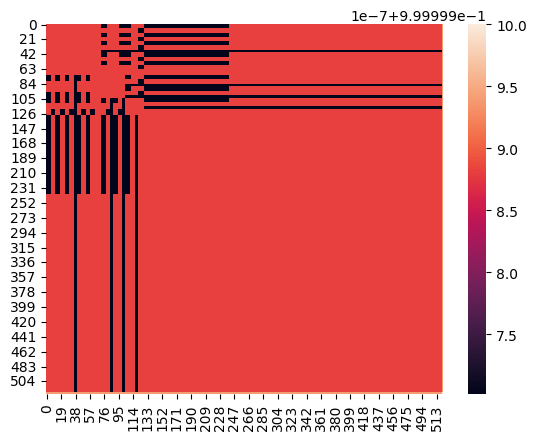

In [180]:
from sklearn.metrics.pairwise import cosine_similarity

# 计算文本特征之间的余弦相似性
text_similarity_matrix = cosine_similarity(text_feature)

# 打印相似性矩阵
print(text_similarity_matrix)
sns.heatmap(text_similarity_matrix)

In [ ]:
for i,cfg in enumerate(['male','female','baseline']):
    data = pd.read_csv(f"/data1/cehou_data/LLM_safety/middle_variables/{cfg}/evaluation_df.csv")
    if i == 0:
        all_data = data
    else:
        all_data = pd.concat([all_data, data], axis=0, ignore_index=True)

In [ ]:
sns.scatterplot(
   x="text_similarity",
   y="img_similarity",
   data=all_data,
   hue='config',
)